In [24]:
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 132.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 153.1 MB/s eta 0:00:00


In [42]:
import boto3
import pandas as pd
import json
import matplotlib.pyplot as plt
import time
from transformers import pipeline

In [27]:
# Define your S3 bucket and file key
bucket_name = 'sagemaker-studio-423623869859-3no3d9ie4hx'
file_key = 'train_spider.json'  # replace with your actual file path

# Initialize the S3 client
s3_client = boto3.client('s3')

# Load the file from S3
obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)
json_train = json.load(obj['Body'])

In [28]:
# Display the data
print(json_train[0])

{'db_id': 'department_management', 'query': 'SELECT count(*) FROM head WHERE age  >  56', 'query_toks': ['SELECT', 'count', '(', '*', ')', 'FROM', 'head', 'WHERE', 'age', '>', '56'], 'query_toks_no_value': ['select', 'count', '(', '*', ')', 'from', 'head', 'where', 'age', '>', 'value'], 'question': 'How many heads of the departments are older than 56 ?', 'question_toks': ['How', 'many', 'heads', 'of', 'the', 'departments', 'are', 'older', 'than', '56', '?'], 'sql': {'from': {'table_units': [['table_unit', 1]], 'conds': []}, 'select': [False, [[3, [0, [0, 0, False], None]]]], 'where': [[False, 3, [0, [0, 10, False], None], 56.0, None]], 'groupBy': [], 'having': [], 'orderBy': [], 'limit': None, 'intersect': None, 'union': None, 'except': None}}


In [29]:
print(json_train[1])

{'db_id': 'department_management', 'query': 'SELECT name ,  born_state ,  age FROM head ORDER BY age', 'query_toks': ['SELECT', 'name', ',', 'born_state', ',', 'age', 'FROM', 'head', 'ORDER', 'BY', 'age'], 'query_toks_no_value': ['select', 'name', ',', 'born_state', ',', 'age', 'from', 'head', 'order', 'by', 'age'], 'question': 'List the name, born state and age of the heads of departments ordered by age.', 'question_toks': ['List', 'the', 'name', ',', 'born', 'state', 'and', 'age', 'of', 'the', 'heads', 'of', 'departments', 'ordered', 'by', 'age', '.'], 'sql': {'from': {'table_units': [['table_unit', 1]], 'conds': []}, 'select': [False, [[0, [0, [0, 8, False], None]], [0, [0, [0, 9, False], None]], [0, [0, [0, 10, False], None]]]], 'where': [], 'groupBy': [], 'having': [], 'orderBy': ['asc', [[0, [0, 10, False], None]]], 'limit': None, 'intersect': None, 'union': None, 'except': None}}


In [30]:
len(json_train)

7000

## collect all questions and sql queries

In [31]:
pd.set_option('display.max_colwidth', None)

list_questions_and_sqls = []

for ele in json_train:
    list_questions_and_sqls.append([ele['question'], ele['query']])
    
df_questions_and_sqls = pd.DataFrame(list_questions_and_sqls, columns=['question', 'sql_query'])

In [ ]:
df_questions_and_sqls.shape

In [ ]:
df_questions_and_sqls.head(5)

In [10]:
df_questions_and_sqls['question_length'] = df_questions_and_sqls['question'].apply(len)
df_questions_and_sqls['sql_query_length'] = df_questions_and_sqls['sql_query'].apply(len)

## distribution of question and sql_query lengths

In [11]:
def compute_quantiles(df, column_name):
    """
    Compute quantiles from 0% to 100% (in increments of 10%) for a specified column in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to compute quantiles for.

    Returns:
    list: A list of quantiles from 0% to 100% for the specified column.
    """
    quantile_range = [i / 100 for i in range(0, 101, 10)]
    quantiles = df[column_name].quantile(quantile_range).tolist()
    return quantiles

### questions

In [12]:
compute_quantiles(df_questions_and_sqls, 'question_length')

[16.0, 42.0, 51.0, 57.0, 63.0, 69.0, 75.0, 82.0, 90.0, 102.0, 224.0]

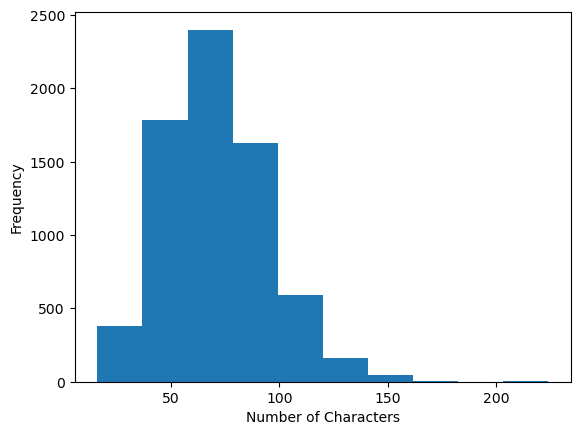

In [13]:
plt.hist(df_questions_and_sqls['question_length'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

### sql queries

In [14]:
compute_quantiles(df_questions_and_sqls, 'sql_query_length')

[18.0, 44.0, 56.0, 67.0, 78.0, 93.0, 113.0, 135.0, 158.0, 189.0, 577.0]

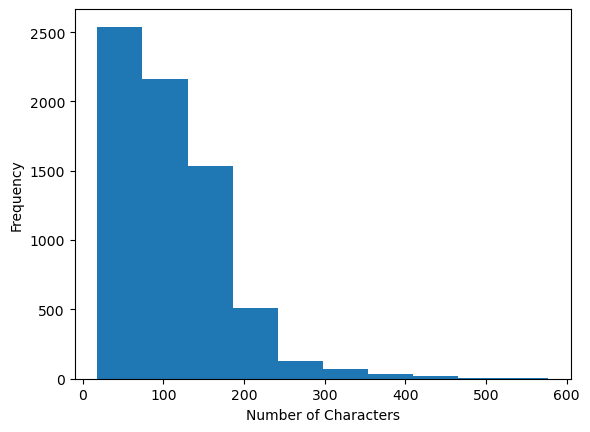

In [15]:
plt.hist(df_questions_and_sqls['sql_query_length'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

In [16]:
# # JSON string
# json_string = "{\"question\": \"some_question\", \"entities_for_tables\": [\"entity1\", \"entity2\", \"entity3\"]}"

# # Parse the JSON string
# parsed_data = json.loads(json_string)

# # Output the parsed data
# print(parsed_data)
# print(type(parsed_data))  # This will show <class 'dict'>
# print(parsed_data['entities_for_tables'])

## NER by predictive AI

In [ ]:
# Load the NER pipeline with the model
nlp_ner = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")

In [ ]:
# Example question as input
question = "today is a nice day"

# Extract entities
entities = nlp_ner(question)
print(entities)

## Bedrock

### list of foundation models in Bedrock

In [12]:
# Use the ListFoundationModels API to show the models that are available in your region.
import boto3
             
# Create an &BR; client in the &region-us-east-1; Region.
bedrock = boto3.client(
    service_name="bedrock"
)

bedrock.list_foundation_models()

{'ResponseMetadata': {'RequestId': 'f786639e-3d64-4434-afd3-82231a9ac66e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 11 Nov 2024 23:36:29 GMT',
   'content-type': 'application/json',
   'content-length': '5174',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'f786639e-3d64-4434-afd3-82231a9ac66e'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-east-2::foundation-model/amazon.titan-embed-text-v2:0',
   'modelId': 'amazon.titan-embed-text-v2:0',
   'modelName': 'Titan Text Embeddings V2',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'outputModalities': ['EMBEDDING'],
   'responseStreamingSupported': False,
   'customizationsSupported': [],
   'inferenceTypesSupported': ['ON_DEMAND'],
   'modelLifecycle': {'status': 'ACTIVE'}},
  {'modelArn': 'arn:aws:bedrock:us-east-2::foundation-model/anthropic.claude-3-5-sonnet-20240620-v1:0',
   'modelId': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
   'modelName': 'Claude 3.5 Son

### Bedrock Inference

In [33]:
bedrock = boto3.client(service_name="bedrock")
response = bedrock.list_foundation_models(byProvider="anthropic")

for summary in response["modelSummaries"]:
    print(summary["modelId"])

anthropic.claude-3-5-sonnet-20240620-v1:0
anthropic.claude-3-haiku-20240307-v1:0:200k
anthropic.claude-3-haiku-20240307-v1:0


In [1]:
import json
import requests
from botocore.auth import SigV4Auth
from botocore.awsrequest import AWSRequest
from botocore.session import Session

# Configuration for Amazon Bedrock API
region = "us-east-2"  # AWS region for Bedrock
service = "bedrock"
endpoint = f"https://bedrock-runtime.{region}.amazonaws.com"
model_id = "amazon.titan-embed-text-v2:0"  # Model ID for Amazon Titan Embedding

# Define the payload for the Titan model
payload = {
    "inputText": "this is where you place your input text",  # Replace with the text you want to embed
    "dimensions": 512,
    "normalize": True
}

# Function to create a signed request with SigV4Auth
def create_signed_request(endpoint, region, service, model_id, payload):
    # Initialize a session and get AWS credentials
    session = Session()
    credentials = session.get_credentials()
    
    # Define the full endpoint URL for invoking the model
    request_url = f"{endpoint}/model/{model_id}/invoke"
    
    # Create an AWSRequest with the payload
    aws_request = AWSRequest(
        method="POST",
        url=request_url,
        data=json.dumps(payload),
        headers={
            "Content-Type": "application/json",
            "Accept": "*/*"
        }
    )
    
    # Sign the request with SigV4Auth
    SigV4Auth(credentials, service, region).add_auth(aws_request)
    
    # Extract signed headers
    headers = dict(aws_request.headers.items())
    
    return request_url, headers, aws_request.body

# Generate signed request
url, headers, body = create_signed_request(endpoint, region, service, model_id, payload)

# Send the API request
response = requests.post(url, headers=headers, data=body)

# Handle the response
if response.status_code == 200:
    output = response.json()
    print("Model Response:", output)
else:
    print(f"Error {response.status_code}: {response.text}")


Model Response: {'embedding': [-0.08712778240442276, 0.025970781221985817, -0.029154296964406967, -0.014409594237804413, 0.07807989418506622, -0.025468120351433754, 0.042558569461107254, 0.04523942619562149, -0.0405479297041893, 0.03451600670814514, -0.08578735589981079, 0.06300009042024612, 0.08411181718111038, 0.028316529467701912, -0.048925600945949554, -0.0246303528547287, 0.015079808421432972, 0.028986742720007896, 0.04222346469759941, -0.02948940359055996, -0.007246685680001974, 0.007875011302530766, 0.011980069801211357, 0.01080719567835331, -0.144766166806221, -0.019687527790665627, -0.06568094342947006, -0.045574530959129333, 0.10455333441495895, -0.0707075446844101, 0.03317558020353317, 0.06266497820615768, 0.053617097437381744, -0.004942825995385647, 0.013739380985498428, 0.07539904117584229, 0.07673946768045425, 0.021446838974952698, 0.0016964784590527415, 0.033343132585287094, 0.04825538769364357, 0.025635674595832825, -0.0016650621546432376, 0.06702136993408203, 0.0549575

In [2]:
output.keys()

dict_keys(['embedding', 'embeddingsByType', 'inputTextTokenCount'])

In [3]:
len(output['embedding'])

512

## claude 3.5 sonnet

In [ ]:
# Initialize the Bedrock client
bedrock = boto3.client("bedrock-runtime", region_name="us-east-2")
s3_client = boto3.client("s3")

# Define S3 bucket and file key
bucket_name = 'sagemaker-studio-423623869859-3no3d9ie4hx'
file_key = 'extracted_entities_in_questions_train.json'

# Function to get entities
def get_entities(question, max_retries=5):
    begin_time = time.time()
    body = json.dumps({
        "max_tokens": 256,
        "messages": [
            {
                "role": "user",
                "content": "Please extract the entities in this following question.\
                            Please only focus on entities that are helpful to identify\
                            relevant table names and column names in a database.\
                            The table names and column names will be used in a SQL query.\
                            Please return your answer in a json string whose keys are\
                            entities_for_tables and entities_for_columns.\
                            The value for each key will be a list of entities.\
                            Please return the json string only without any extra words.\
                            question: {}".format(question)
            }
        ],
        "anthropic_version": "bedrock-2023-05-31"
    })

    retries = 0
    while retries < max_retries:
        try:
            response = bedrock.invoke_model(
                body=body,
                modelId="us.anthropic.claude-3-5-sonnet-20240620-v1:0"
            )
            response_body = json.loads(response.get("body").read())
            end_time = time.time()
            print(f"Total time taken is: {end_time - begin_time}")
            return json.loads(response_body.get("content")[0]['text'])

        except Exception as e:
            print(f"Request failed with error: {e}. Retrying...")
            retries += 1
            time.sleep(2 ** retries)

    print("Max retries exceeded. Could not complete the request.")
    return {}

# Function to upload data to S3
def upload_to_s3(data, bucket, key):
    with open('extracted_entities.json', 'w') as json_file:
        json.dump(data, json_file)
    s3_client.upload_file('extracted_entities.json', bucket, key)
    print(f"Uploaded data to S3 at s3://{bucket}/{key}")

# Main loop to process questions and save results
questions_entities = {}

for ind, row in df_questions_and_sqls.iterrows():
    question = row['question']
    result = get_entities(question)
    questions_entities[question] = result
    print(ind)

    # Upload to S3 every 10 questions
    if (i + 1) % 10 == 0:
        upload_to_s3(questions_entities, bucket_name, file_key)

# Final upload after all questions are processed
upload_to_s3(questions_entities, bucket_name, file_key)